In [1]:
#!pip install catboost

In [99]:
#!pip install shap

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import shap

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [5]:
sns.set()

In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# **Data Understanding**

загрузим данные

In [7]:
df_dislok = pd.read_parquet('/content/drive/MyDrive/datawago23/dislok_wagons.parquet')
df_pr_rems = pd.read_parquet('/content/drive/MyDrive/datawago23/pr_rems.parquet')
df_tr_rems = pd.read_parquet('/content/drive/MyDrive/datawago23/tr_rems.parquet')
df_wag_params = pd.read_parquet('/content/drive/MyDrive/datawago23/wag_params.parquet')
df_probeg = pd.read_parquet('/content/drive/MyDrive/datawago23/wagons_probeg_ownersip.parquet')

In [8]:
df_dislok2 = pd.read_parquet('/content/drive/MyDrive/datawago23/dislok_wagons2.parquet')
df_pr_rems2 = pd.read_parquet('/content/drive/MyDrive/datawago23/pr_rems2.parquet')
df_tr_rems2 = pd.read_parquet('/content/drive/MyDrive/datawago23/tr_rems2.parquet')
df_wag_params2 = pd.read_parquet('/content/drive/MyDrive/datawago23/wag_params2.parquet')
df_probeg2 = pd.read_parquet('/content/drive/MyDrive/datawago23/wagons_probeg_ownersip2.parquet')

In [9]:
y_train = pd.read_csv('/content/drive/MyDrive/datawago23/y_train.csv')
y_test = pd.read_csv('/content/drive/MyDrive/datawago23/y_test.csv')
y_predict = pd.read_csv('/content/drive/MyDrive/datawago23/y_predict.csv')

соединим февральские данные

In [10]:
df_dislok = pd.concat([df_dislok, df_dislok2])
df_pr_rems = pd.concat([df_pr_rems, df_pr_rems2])
df_tr_rems = pd.concat([df_tr_rems, df_tr_rems2])
df_wag_params = pd.concat([df_wag_params, df_wag_params2])
df_probeg = pd.concat([df_probeg, df_probeg2])

In [11]:
y_train = pd.concat([y_train, y_test])

In [12]:
df_dislok = df_dislok.drop_duplicates().reset_index(drop=True)
df_tr = df_tr_rems.drop_duplicates().reset_index(drop=True)

In [13]:
df_dislok = df_dislok.drop(['id_road_disl', 'st_id_dest', 'id_road_dest', 'st_id_send', 'id_road_send', 'distance', 'fr_id', 'last_fr_id'], axis=1)

превратим даты в фитчи

In [14]:
df_dislok['kap_year'] = df_dislok['date_kap'].dt.year
df_dislok['kap_month'] = df_dislok['date_kap'].dt.month
df_dislok['kap_day'] = df_dislok['date_kap'].dt.day

In [15]:
df_dislok['plrem_year'] = df_dislok['date_pl_rem'].dt.year
df_dislok['plrem_month'] = df_dislok['date_pl_rem'].dt.month
df_dislok['plrem_day'] = df_dislok['date_pl_rem'].dt.day

In [16]:
df_dislok['dep_year'] = df_dislok['date_dep'].dt.year
df_dislok['dep_month'] = df_dislok['date_dep'].dt.month
df_dislok['plrem_day'] = df_dislok['date_dep'].dt.day

In [17]:
df_dislok = df_dislok.drop(['date_kap', 'date_pl_rem', 'date_dep'], axis=1)

In [18]:
df_dislok

,plan_date,wagnum,kod_vrab,ost_prob,isload,kap_year,kap_month,kap_day,plrem_year,plrem_month,plrem_day,dep_year,dep_month
0,2022-08-01,1071,0,36899,0,NaN,NaN,NaN,2023,2,16.0,2020.0,2.0
1,2022-08-02,1071,0,36899,1,NaN,NaN,NaN,2023,2,16.0,2020.0,2.0
2,2022-08-03,1071,0,36711,1,NaN,NaN,NaN,2023,2,16.0,2020.0,2.0
3,2022-08-04,1071,0,36711,1,NaN,NaN,NaN,2023,2,16.0,2020.0,2.0
4,2022-08-05,1071,0,36711,1,NaN,NaN,NaN,2023,2,16.0,2020.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7228208,2023-03-01,30358,1,33717,0,NaN,NaN,NaN,2023,6,27.0,2020.0,6.0
7228209,2023-03-01,21168,0,156097,0,2020.0,5.0,19.0,2023,5,21.0,2017.0,11.0
7228210,2023-03-01,27006,0,145150,0,2015.0,12.0,7.0,2023,7,22.0,2020.0,7.0
7228211,2023-03-01,6135,1,2373,0,2009.0,10.0,2.0,2023,4,9.0,2020.0,4.0


In [19]:
df_wag_params

,wagnum,model,rod_id,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,date_iskl,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype
3218,26318,12-600-04,1,682,682,85.0,240,1992-12-25,2022-04-27,5,2023-02-16,160,160,2,9,3,6,11,110000,0
19128,28344,12-132,1,700,700,88.0,240,2003-08-12,2024-12-24,0,2022-12-14,110,160,2,9,2,1,12,0,0
21526,8099,11-286,0,670,670,138.0,270,1995-08-31,2027-10-01,1,NaT,110,160,2,9,2,1,1,160000,1
32353,33350,12-9850-02,1,750,750,90.0,248,2014-10-27,2047-02-05,19,NaT,250,500,2,11,2,7,12,250000,1
81,5308,11-276,0,680,680,122.0,260,1995-09-17,2027-09-28,1,NaT,110,160,2,9,2,1,11,160000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33703,18766,11-280,0,680,680,138.0,259,2013-01-07,2046-03-20,1,NaT,110,160,2,9,2,7,12,160000,0
33704,18769,11-280,0,680,680,138.0,259,2013-01-18,2046-02-14,1,NaT,110,160,2,9,2,7,12,160000,0
33705,18899,11-280,0,680,680,138.0,260,2013-07-24,2044-03-03,1,NaT,110,160,2,9,2,7,11,160000,0
33706,18912,11-280,0,680,680,138.0,259,2015-02-28,2044-08-04,1,NaT,110,160,2,9,2,7,11,160000,0


изменим тип с str на int

In [20]:
df_wag_params['tipvozd'] = df_wag_params['tipvozd'].astype(int)

In [21]:
df_wag_params['build_year'] = df_wag_params['date_build'].dt.year
df_wag_params['build_month'] = df_wag_params['date_build'].dt.month
df_wag_params['build_day'] = df_wag_params['date_build'].dt.day

In [22]:
df_wag_params['sl_year'] = df_wag_params['srok_sl'].dt.year
df_wag_params['sl_month'] = df_wag_params['srok_sl'].dt.month
df_wag_params['sl_day'] = df_wag_params['srok_sl'].dt.day

In [23]:
df_wag_params = df_wag_params.drop(['date_build', 'srok_sl', 'date_iskl'], axis=1)

заполним пропуски

In [24]:
df_wag_params['tippogl'] = df_wag_params['tippogl'].fillna(11)

In [25]:
df_probeg

,repdate,wagnum,ost_prob,manage_type,rod_id,reestr_state,ownership_type,month
0,2022-08-01,33361,7541,0,1,1,0,8
1,2022-08-02,33361,7243,0,1,1,0,8
2,2022-08-03,33361,6990,0,1,1,0,8
3,2022-08-04,33361,6347,0,1,1,0,8
4,2022-08-05,33361,6027,0,1,1,0,8
...,...,...,...,...,...,...,...,...
9249482,2023-02-24,8061,139890,0,0,1,0,2
9249483,2023-02-25,8061,139890,0,0,1,0,2
9249484,2023-02-26,8061,139890,0,0,1,0,2
9249485,2023-02-27,8061,139890,0,0,1,0,2


In [26]:
df_probeg = df_probeg.drop('month', axis=1)

In [27]:
df_pr_rems

,wagnum,rem_month,rod_id,model,road_id_send,road_id_rem,kod_vrab,st_id_send,st_id_rem,distance,month
0,15000,2022-08-05,1,12-132,3,3,0,493,493,37.0,8
2,25485,2022-08-21,1,12-132-03,13,13,0,6152,4793,360.0,8
3,25944,2022-08-09,1,12-132-03,13,13,1,6152,4793,322.0,8
4,24080,2022-08-13,1,12-296-01,13,13,0,6152,4793,308.0,8
5,28612,2022-08-09,1,12-132,13,13,0,6152,4793,373.0,8
...,...,...,...,...,...,...,...,...,...,...,...
1883,5049,2023-02-28,0,11-2135-01,5,4,0,1558,2400,1139.0,2
1884,15915,2023-02-28,0,11-1807-01,12,12,0,12610,5167,308.0,2
1890,7276,2023-02-24,0,11-286,6,7,0,12920,3735,2519.0,2
1895,25459,2023-02-02,1,12-132-03,7,6,0,4025,4261,935.0,2


In [28]:
df_pr_rems['rem_month'].max()

Timestamp('2023-02-28 00:00:00')

In [29]:
df_tr_rems

,wagnum,rem_month,kod_vrab,neis1_kod,neis2_kod,neis3_kod,mod1_kod,mod2_kod,mod3_kod,mod4_kod,mod5_kod,mod6_kod,mod7_kod,road_id_send,gr_probeg,por_probeg,st_id_send
0,29938,2022-08-01,3,0,98,54,7,4,2,0,0,0,0,38,87913,37467,10522
1,29938,2022-08-01,3,14,98,54,7,4,2,0,0,0,0,38,87913,37467,10441
2,29852,2022-08-01,2,0,98,54,7,4,2,0,0,0,0,28,81824,45579,4789
3,29852,2022-08-01,2,36,98,54,7,4,2,0,0,0,0,28,81824,45579,4789
4,13674,2022-08-01,2,95,98,54,7,4,2,0,0,0,0,28,64130,34697,4789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,5300,2023-02-01,3,6,98,54,7,4,2,0,0,0,0,42,23945,10147,11464
7496,13550,2023-02-01,3,0,98,54,1,4,2,0,0,0,0,16,92068,38886,4421
7497,33743,2023-02-01,2,0,98,54,7,4,2,0,0,0,0,28,16408,7664,6321
7498,33743,2023-02-01,2,31,98,54,7,4,2,0,0,0,0,28,16408,7664,6321


# **Merging and split**

отложим выборку, по которой будем предсказывать март

In [30]:
oot_df = df_probeg[df_probeg['repdate'] == '2023-02-28']

In [31]:
df_probeg = df_probeg[df_probeg['repdate'].dt.day==1]

In [32]:
df_probeg = pd.concat([df_probeg, oot_df])

In [33]:
data = df_probeg.merge(df_wag_params, on='wagnum')

In [34]:
data = data.merge(df_dislok, left_on=['repdate','wagnum'], right_on=['plan_date', 'wagnum'])

In [35]:
data = data.drop(['plan_date', 'rod_id_y', 'ost_prob_y'], axis=1)

закодируем фитчу model

In [36]:
le = LabelEncoder()

In [37]:
data['model'] = le.fit_transform(data['model'])

In [38]:
data

,repdate,wagnum,ost_prob_x,manage_type,rod_id_x,reestr_state,ownership_type,model,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,zavod_build,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,build_year,build_month,build_day,sl_year,sl_month,sl_day,kod_vrab,isload,kap_year,kap_month,kap_day,plrem_year,plrem_month,plrem_day,dep_year,dep_month
0,2022-08-01,33361,7541,0,1,1,0,21,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,0,0,2020.0,2.0,17.0,2023,2,12.0,2017.0,9.0
1,2022-08-01,33361,7541,0,1,1,0,21,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,0,0,2020.0,2.0,17.0,2023,2,12.0,2017.0,9.0
2,2022-09-01,33361,4105,0,1,1,0,21,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,0,1,2020.0,2.0,17.0,2023,2,12.0,2017.0,9.0
3,2022-09-01,33361,4105,0,1,1,0,21,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,0,1,2020.0,2.0,17.0,2023,2,12.0,2017.0,9.0
4,2022-10-01,33361,2185,0,1,1,0,21,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,0,0,2020.0,2.0,17.0,2023,2,12.0,2017.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542481,2023-02-01,8061,139990,0,0,1,0,15,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10,0,0,2010.0,12.0,29.0,2022,10,8.0,2019.0,10.0
542482,2023-02-28,8061,139890,0,0,1,0,15,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10,0,0,2010.0,12.0,29.0,2022,10,8.0,2019.0,10.0
542483,2023-02-28,8061,139890,0,0,1,0,15,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10,0,0,2010.0,12.0,29.0,2022,10,8.0,2019.0,10.0
542484,2022-12-01,33350,90841,0,1,0,0,48,750,750,90.0,248,19,250,500,2,11,2,7,12,250000,1,2014,10,27,2047,2,5,0,0,NaN,NaN,NaN,2022,7,25.0,2020.0,7.0


удалим дубли

In [42]:
data = data.drop_duplicates().reset_index(drop=True)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271243 entries, 0 to 271242
Data columns (total 38 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   repdate             271243 non-null  datetime64[ns]
 1   wagnum              271243 non-null  int64         
 2   ost_prob_x          260453 non-null  Int64         
 3   manage_type         271243 non-null  int64         
 4   rod_id_x            271243 non-null  int64         
 5   reestr_state        271243 non-null  int64         
 6   ownership_type      271243 non-null  int64         
 7   model               271243 non-null  int64         
 8   gruz                271243 non-null  Int64         
 9   cnsi_gruz_capacity  271243 non-null  Int64         
 10  cnsi_volumek        271243 non-null  Float64       
 11  tara                271243 non-null  Int64         
 12  zavod_build         271243 non-null  int64         
 13  cnsi_probeg_dr      271243 no

In [44]:
oot = data[data['repdate'] == '2023-02-28']

заполним пропуски

In [47]:
oot['ost_prob_x'] = oot['ost_prob_x'].fillna(oot['ost_prob_x'].median())

<ipython-input-47-5f9b96ae0a0d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oot['ost_prob_x'] = oot['ost_prob_x'].fillna(oot['ost_prob_x'].median())


In [41]:
#oot = oot.drop('repdate', axis=1)

In [48]:
oot.shape

(33699, 38)

In [49]:
y_train

,wagnum,month,target_month,target_day
0,33361,2023-01-01,0,0
1,33364,2023-01-01,0,0
2,33366,2023-01-01,0,0
3,33358,2023-01-01,0,0
4,33349,2023-01-01,0,0
...,...,...,...,...
33703,17621,2023-02-01,0,0
33704,25045,2023-02-01,0,0
33705,27156,2023-02-01,0,0
33706,21361,2023-02-01,0,0


In [50]:
y_train['month'] = pd.to_datetime(y_train['month'])

In [51]:
y_train['month'].max()

Timestamp('2023-02-01 00:00:00')

In [52]:
data = data.merge(y_train, left_on=['wagnum', 'repdate'], right_on=['wagnum', 'month'])

In [53]:
data = data.drop('month', axis=1)

In [54]:
data

,repdate,wagnum,ost_prob_x,manage_type,rod_id_x,reestr_state,ownership_type,model,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,zavod_build,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,build_year,build_month,build_day,sl_year,sl_month,sl_day,kod_vrab,isload,kap_year,kap_month,kap_day,plrem_year,plrem_month,plrem_day,dep_year,dep_month,target_month,target_day
0,2022-08-01,33361,7541,0,1,1,0,21,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,0,0,2020.0,2.0,17.0,2023,2,12.0,2017.0,9.0,0,0
1,2022-09-01,33361,4105,0,1,1,0,21,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,0,1,2020.0,2.0,17.0,2023,2,12.0,2017.0,9.0,0,0
2,2022-10-01,33361,2185,0,1,1,0,21,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,0,0,2020.0,2.0,17.0,2023,2,12.0,2017.0,9.0,0,0
3,2022-11-01,33361,1236,0,1,1,0,21,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,0,0,2020.0,2.0,17.0,2023,2,12.0,2017.0,9.0,1,0
4,2022-12-01,33361,159916,0,1,1,0,21,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,0,0,2020.0,2.0,17.0,2023,2,12.0,2017.0,9.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237539,2022-11-01,8061,157921,0,0,1,0,15,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10,0,1,2010.0,12.0,29.0,2022,10,8.0,2019.0,10.0,0,0
237540,2022-12-01,8061,156895,0,0,1,0,15,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10,0,0,2010.0,12.0,29.0,2022,10,8.0,2019.0,10.0,0,0
237541,2023-01-01,8061,149388,0,0,1,0,15,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10,0,0,2010.0,12.0,29.0,2022,10,8.0,2019.0,10.0,0,0
237542,2023-02-01,8061,139990,0,0,1,0,15,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10,0,0,2010.0,12.0,29.0,2022,10,8.0,2019.0,10.0,0,0


# **ML**

In [55]:
data = data.sort_values('repdate')

In [56]:
data

,repdate,wagnum,ost_prob_x,manage_type,rod_id_x,reestr_state,ownership_type,model,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,zavod_build,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,build_year,build_month,build_day,sl_year,sl_month,sl_day,kod_vrab,isload,kap_year,kap_month,kap_day,plrem_year,plrem_month,plrem_day,dep_year,dep_month,target_month,target_day
0,2022-08-01,33361,7541,0,1,1,0,21,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,0,0,2020.0,2.0,17.0,2023,2,12.0,2017.0,9.0,0,0
67951,2022-08-01,1743,<NA>,0,0,1,0,5,670,670,161.0,267,1,110,160,2,9,2,19,12,160000,0,2020,4,20,2052,12,7,0,1,NaN,NaN,NaN,2022,10,NaN,NaN,NaN,0,0
196855,2022-08-01,5032,43765,0,0,1,0,5,670,670,161.0,268,1,110,160,2,9,2,16,11,160000,0,2015,11,19,2046,6,2,0,1,NaN,NaN,NaN,2023,4,8.0,2020.0,4.0,0,0
67958,2022-08-01,1819,<NA>,0,0,1,0,5,670,670,161.0,268,1,110,160,2,9,2,19,12,160000,0,2021,10,6,2053,2,16,0,0,NaN,NaN,NaN,2022,10,NaN,NaN,NaN,0,0
67965,2022-08-01,1955,<NA>,0,0,1,0,5,670,670,161.0,267,1,110,160,2,9,2,10,11,160000,0,2019,11,12,2053,12,22,0,0,NaN,NaN,NaN,2023,3,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172791,2023-02-01,27655,1145,1,1,1,0,22,695,695,88.0,240,0,110,160,2,9,2,7,11,160000,1,2012,4,23,2033,8,28,1,0,NaN,NaN,NaN,2023,8,16.0,2020.0,8.0,1,0
207920,2023-02-01,3353,427664,0,0,1,0,6,680,680,161.0,257,1,320,320,43,27,2,10,12,500000,0,2021,10,28,2054,2,6,0,1,NaN,NaN,NaN,2026,9,NaN,NaN,NaN,0,0
49503,2023-02-01,27658,135102,1,1,1,0,22,695,695,88.0,240,0,110,160,2,9,2,7,11,160000,1,2012,5,17,2034,12,18,1,0,NaN,NaN,NaN,2023,4,29.0,2020.0,4.0,0,0
108207,2023-02-01,7041,43134,0,0,1,0,3,672,672,138.0,265,17,110,160,2,9,2,1,11,160000,0,2009,11,23,2040,4,27,0,1,2021.0,3.0,17.0,2024,3,10.0,2018.0,4.0,0,0


In [57]:
data['ost_prob_x'] = data['ost_prob_x'].fillna(data['ost_prob_x'].median())

In [58]:
data.isna().sum()

repdate                    0
wagnum                     0
ost_prob_x                 0
manage_type                0
rod_id_x                   0
reestr_state               0
ownership_type             0
model                      0
gruz                       0
cnsi_gruz_capacity         0
cnsi_volumek               0
tara                       0
zavod_build                0
cnsi_probeg_dr             0
cnsi_probeg_kr             0
kuzov                      0
telega                     0
tormoz                     0
tipvozd                    0
tippogl                    0
norma_km                   0
ownertype                  0
build_year                 0
build_month                0
build_day                  0
sl_year                    0
sl_month                   0
sl_day                     0
kod_vrab                   0
isload                     0
kap_year              104847
kap_month             104847
kap_day               104847
plrem_year                 0
plrem_month   

разделим данные на выборки

In [59]:
train = data[data['repdate'] != '2023-02-01'].drop('repdate', axis=1)
valid = data[data['repdate'] == '2023-02-01'].drop('repdate', axis=1)

In [60]:
x_train = train.drop(['target_month', 'target_day'], axis=1)
x_valid = valid.drop(['target_month', 'target_day'], axis=1)

In [61]:
y_train_m = train['target_month']
y_valid_m = valid['target_month']

y_train_d = train['target_day']
y_valid_d = valid['target_day']

обучим модели

In [561]:
model_m = CatBoostClassifier(random_state=18, eval_metric='F1', verbose=250, learning_rate=0.01, iterations=5)
model_m.fit(x_train, y_train_m, eval_set=(x_valid, y_valid_m))

0:	learn: 0.5654980	test: 0.5714286	best: 0.5714286 (0)	total: 23.6ms	remaining: 94.5ms
4:	learn: 0.5597276	test: 0.5525581	best: 0.5714286 (0)	total: 133ms	remaining: 0us

bestTest = 0.5714285714
bestIteration = 0

Shrink model to first 1 iterations.


In [604]:
model_d = CatBoostClassifier(random_state=165, eval_metric='F1', verbose=250, learning_rate=0.15, iterations=2000)
model_d.fit(x_train, y_train_d, eval_set=(x_valid, y_valid_d))

In [605]:
model_d.fit(x_train, y_train_d, eval_set=(x_valid, y_valid_d))

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 24.8ms	remaining: 49.7s
250:	learn: 0.4503401	test: 0.2267760	best: 0.2527174 (202)	total: 7.69s	remaining: 53.6s
500:	learn: 0.5917603	test: 0.2379679	best: 0.2527174 (202)	total: 14.2s	remaining: 42.6s
750:	learn: 0.6700909	test: 0.2095238	best: 0.2527174 (202)	total: 21.2s	remaining: 35.3s
1000:	learn: 0.7300868	test: 0.2204515	best: 0.2527174 (202)	total: 28s	remaining: 28s
1250:	learn: 0.7798148	test: 0.2351387	best: 0.2527174 (202)	total: 34.8s	remaining: 20.8s
1500:	learn: 0.8164200	test: 0.2307692	best: 0.2527174 (202)	total: 41.9s	remaining: 13.9s
1750:	learn: 0.8472771	test: 0.2278146	best: 0.2527174 (202)	total: 48.4s	remaining: 6.88s
1999:	learn: 0.8694918	test: 0.2342105	best: 0.2527174 (202)	total: 55.5s	remaining: 0us

bestTest = 0.2527173913
bestIteration = 202

Shrink model to first 203 iterations.


In [606]:
model_m = CatBoostClassifier(random_state=18, eval_metric='F1', verbose=False, learning_rate=0.01, iterations=1)
model_m.fit(pd.concat([x_train, x_valid]), pd.concat([y_train_m, y_valid_m]))

In [607]:
model_d = CatBoostClassifier(random_state=42, eval_metric='F1', verbose=False, learning_rate=0.15, iterations=455)
model_m.fit(pd.concat([x_train, x_valid]), pd.concat([y_train_d, y_valid_d]))

сделаем предсказания и сохраним их

In [608]:
y_predict = pd.read_csv('/content/drive/MyDrive/datawago23/y_predict.csv')

In [609]:
y_predict

,wagnum,month
0,33361,2023-03-01
1,33364,2023-03-01
2,33366,2023-03-01
3,33358,2023-03-01
4,33349,2023-03-01
...,...,...
33702,17621,2023-03-01
33703,25045,2023-03-01
33704,27156,2023-03-01
33705,21361,2023-03-01


In [610]:
y_predict['m'] = '2023-02-28'

In [611]:
y_predict['m'] = pd.to_datetime(y_predict['m'])

In [612]:
temp = y_predict.merge(oot, left_on=['wagnum', 'm'], right_on=['wagnum', 'repdate'], how='left')

In [613]:
temp = temp.drop(['m', 'repdate', 'month'], axis=1)

In [614]:
temp = temp.fillna(0)

In [615]:
m_preds = model_m.predict(temp)
d_preds = model_d.predict(temp)

In [616]:
m_preds.shape

(33707,)

In [617]:
y_predict = y_predict.drop('m', axis=1)
y_predict

,wagnum,month
0,33361,2023-03-01
1,33364,2023-03-01
2,33366,2023-03-01
3,33358,2023-03-01
4,33349,2023-03-01
...,...,...
33702,17621,2023-03-01
33703,25045,2023-03-01
33704,27156,2023-03-01
33705,21361,2023-03-01


In [618]:
y_predict['target_month'] = m_preds
y_predict['target_day'] = d_preds

In [619]:
y_predict

,wagnum,month,target_month,target_day
0,33361,2023-03-01,0,0
1,33364,2023-03-01,0,0
2,33366,2023-03-01,0,0
3,33358,2023-03-01,0,0
4,33349,2023-03-01,0,0
...,...,...,...,...
33702,17621,2023-03-01,0,0
33703,25045,2023-03-01,0,0
33704,27156,2023-03-01,0,0
33705,21361,2023-03-01,0,0


In [620]:
y_predict.to_csv('14_preds.csv', index=False)

сохраним модели

In [473]:
pickle.dump(model_m, open('model_for_month.pkl', 'wb'))
pickle.dump(model_d, open('model_for_day.pkl', 'wb'))

изучим важность фитчей для моделей

In [101]:
explainer = shap.TreeExplainer(model_m)
shap_values = explainer.shap_values(pd.concat([x_train, x_valid]))

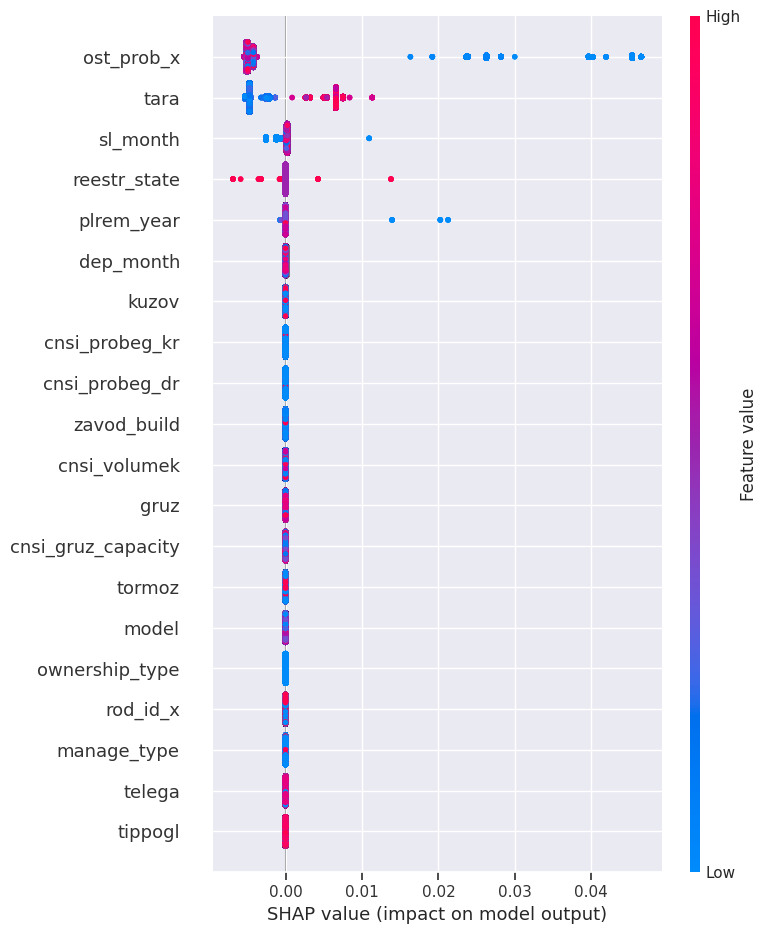

In [102]:
shap.summary_plot(shap_values, pd.concat([x_train, x_valid]))

In [103]:
explainer = shap.TreeExplainer(model_d)
shap_values = explainer.shap_values(pd.concat([x_train, x_valid]))

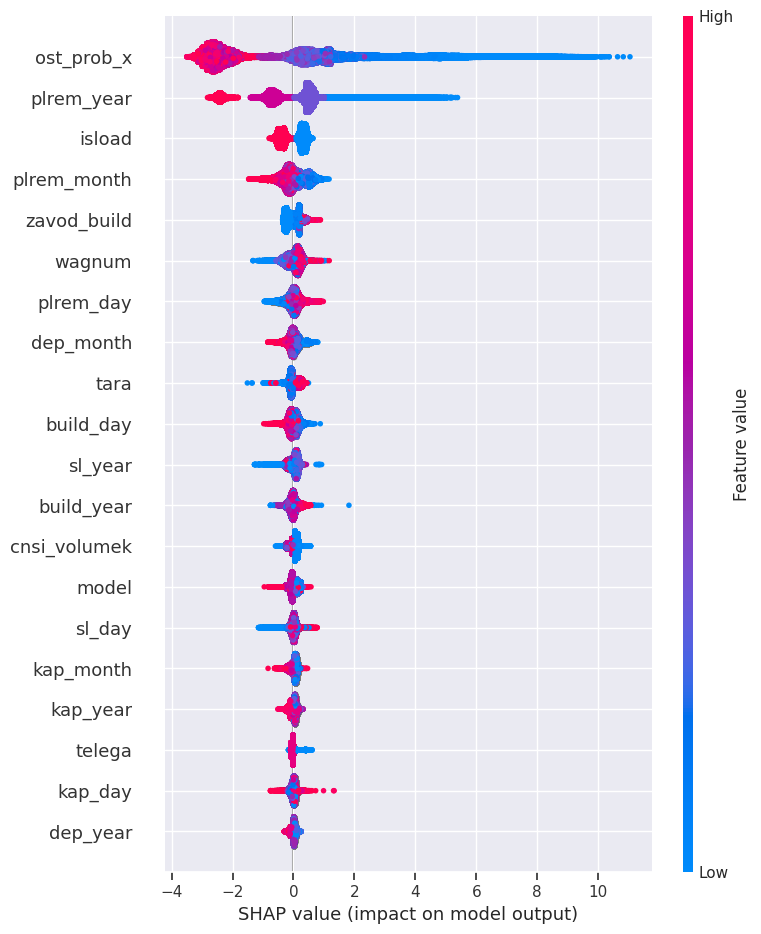

In [104]:
shap.summary_plot(shap_values, pd.concat([x_train, x_valid]))